El transfer learning consiste en utilizar el conocimiento guardado en un modelo para resolver un problema diferente pero relacionado. En la práctica, poca gente entrena una red Convolucional desde cero, porque es relativamente raro tener un dataset suficientemente grande, lo más común es descargar un modelo pre entrenado en un dataset muy grande como ImageNet que contiene 1.2 millones de imágenes con 1000 categorías y luego utilizar ese modelo como una iniciación de los parámetros de la red o como in fixed feature extractor. Este último caso es el que voy a hacer. Para ello, vamos a coger una ResNet 18, “congelar” todas las capa menos la última, que la eliminaremos ya que en un inicio tiene 1000 salidas y la cambiaremos por una que solo tenga 2. Tras esto entrenaremos el nuevo modelo en el dataset de perros contra gatos. [Descargar el dataset](https://www.kaggle.com/c/dogs-vs-cats/)

In [1]:
import numpy as np
from PIL import Image
from glob import glob
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models

from torchvision.utils import make_grid

import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline

In [ ]:
class Petset(Dataset):
    def __init__(self, root, mode='train'):
#         Las transforms son muy importantes para el transfer learning pues todos 
#         los modelos pre entrenados esperan imágenes normalizadas de la misma manera: mini-batches 
#         de imagenes con tres canales rgb con altura y anchura mínimo de 224 píxeles, además 
#         todas las imágenes tienen que estar en un rango de 0 y 1 y estar normalizadas 
#         usando mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].
        
#         Por defecto Pytorch transforma las imágenes a tensores en un rango de 0 y 1 pero hay 
#         que hacer que sean de tamaño 224x224 y con la normalización que nos pide, para ello 
#         utilizaremos las transformaciones de pytorch de esta manera.

        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        ])
        
        self.mode = mode
        
        if self.mode =='train':
            self.cats = glob(os.path.join(root,"cat.*"))
            self.dogs = glob(os.path.join(root,"dog.*"))   
        else:
            self.imgs = glob(os.path.join(root,"*"))   

    def __len__(self):
        if self.mode == 'train':
            return len(self.cats)+len(self.dogs)
        else:
            return len(self.imgs)

    def __getitem__(self, idx):
        if self.mode == 'train':
            if idx < len(self.cats):
                img = Image.open(self.cats[idx])
                label = 1
            else:
                img = Image.open(self.dogs[idx-len(self.cats)])
                label = 0
        else:
            img = Image.open(self.imgs[idx])
            label = -1
        
        
        img = self.transform(img)
        
        return img, label

In [3]:
bs=16
num_workers=2

lr = 1e-3

classes = ['dog','cat']

Ahora podemos instanciar la clase que acabamos de crear y crear nuestros Dataloader que nos "Batchea" los datos, nos los mezcla y carga utilizando multiprocesos para posteriormente poder usar un bucle for e iterar por ellos.

In [4]:
trainset = Petset('dogs-vs-cats/train')
testset = Petset('dogs-vs-cats/test1', mode='test')

trainloader = DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=num_workers)
testloader = DataLoader(testset, batch_size=bs, shuffle=False, num_workers=num_workers)

Vamos a cargar nuestro modelo pre entrenado y congelar toda la red menos la última capa

In [5]:
resnet18 = models.resnet18(pretrained=True) 

for param in resnet18.parameters():
    param.requires_grad = False

Como he dicho antes necesitamos deshacernos de la última capa y reemplazarla por una con solo 2 salidas. Primero vamos a ver como es: 

In [6]:
resnet18.fc

Linear(in_features=512, out_features=1000, bias=True)

In [7]:
in_features=resnet18.fc.in_features

Vemos que tiene de entrada 2048 características y 1000 de salida, ahora sobre escribiremos esta capa de manera que solo tenga 2 salidas. Y ya tendremos a nuestro modelo preparado.

In [8]:
resnet18.fc = nn.Linear(in_features, len(classes))

In [9]:
resnet18.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(resnet18.fc.parameters(), lr=lr)

In [10]:
import time
epochs = 10

start = time.time()
for epoch in range(epochs):
    total = 0
    correct = 0
    for imgs, labels in trainloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = resnet18(imgs)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        accuracy = 100 * correct / total
        
    print(f"Epoch: {epoch+1}/{epochs}, Loss: {loss.item()}, Accuracy: {accuracy}")

    
print(f"{time.strftime('%H:%M:%S', time.gmtime(time.time()-start))} entrenando la red 😪")

Epoch: 1/10, Loss: 0.002662450075149536, Accuracy: 90.864
Epoch: 2/10, Loss: 0.37838172912597656, Accuracy: 91.604
Epoch: 3/10, Loss: 0.12185510993003845, Accuracy: 92.152
Epoch: 4/10, Loss: 0.29869920015335083, Accuracy: 91.984
Epoch: 5/10, Loss: 0.12772133946418762, Accuracy: 91.936
Epoch: 6/10, Loss: 1.055576205253601, Accuracy: 92.048
Epoch: 7/10, Loss: 1.5857045650482178, Accuracy: 92.3
Epoch: 8/10, Loss: 0.38268646597862244, Accuracy: 91.916
Epoch: 9/10, Loss: 0.04819785803556442, Accuracy: 92.084
Epoch: 10/10, Loss: 0.31190770864486694, Accuracy: 92.076
00:19:44 entrenando la red 😪


In [11]:
torch.save(resnet18.state_dict(), "./weights.pth")

In [12]:
# resnet18 = models.resnet50()
# in_features=resnet18.fc.in_features
# resnet18.fc = nn.Linear(in_features, len(classes))
# resnet18.load_state_dict(torch.load("./weights.pth"))
# resnet18.to(device)
# resnet18.eval()

In [13]:
resnet18.eval()

n = 32
imgs_n_preds = []
for i in range(n):
    imgs, _ = next(iter(testloader)) 
    
    imgs = Variable(imgs).to(device)
    
    outputs = resnet18(imgs)
    
    _, preds = torch.max(outputs, 1)
    
    imgs_n_preds.append([imgs.cpu().detach().numpy(), preds.cpu().detach().numpy()])

In [34]:
def show_train_preds(array, n=16):
    
    fig =plt.figure(figsize=(20,80))
    n_=0
    for imgs, preds in array:
        
        for i in range(len(imgs)):
            ax = plt.subplot(n//2, 2,i+1)
            ax.axis('off')
            ax.set_title(f"Predicted: {classes[preds[i]]}")

            img = imgs[i].transpose((1, 2, 0))

                #Xplain
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)

            plt.imshow(img)
            n_+=1
            if n_ == n:
                break
            
        if n_ == n:
            break


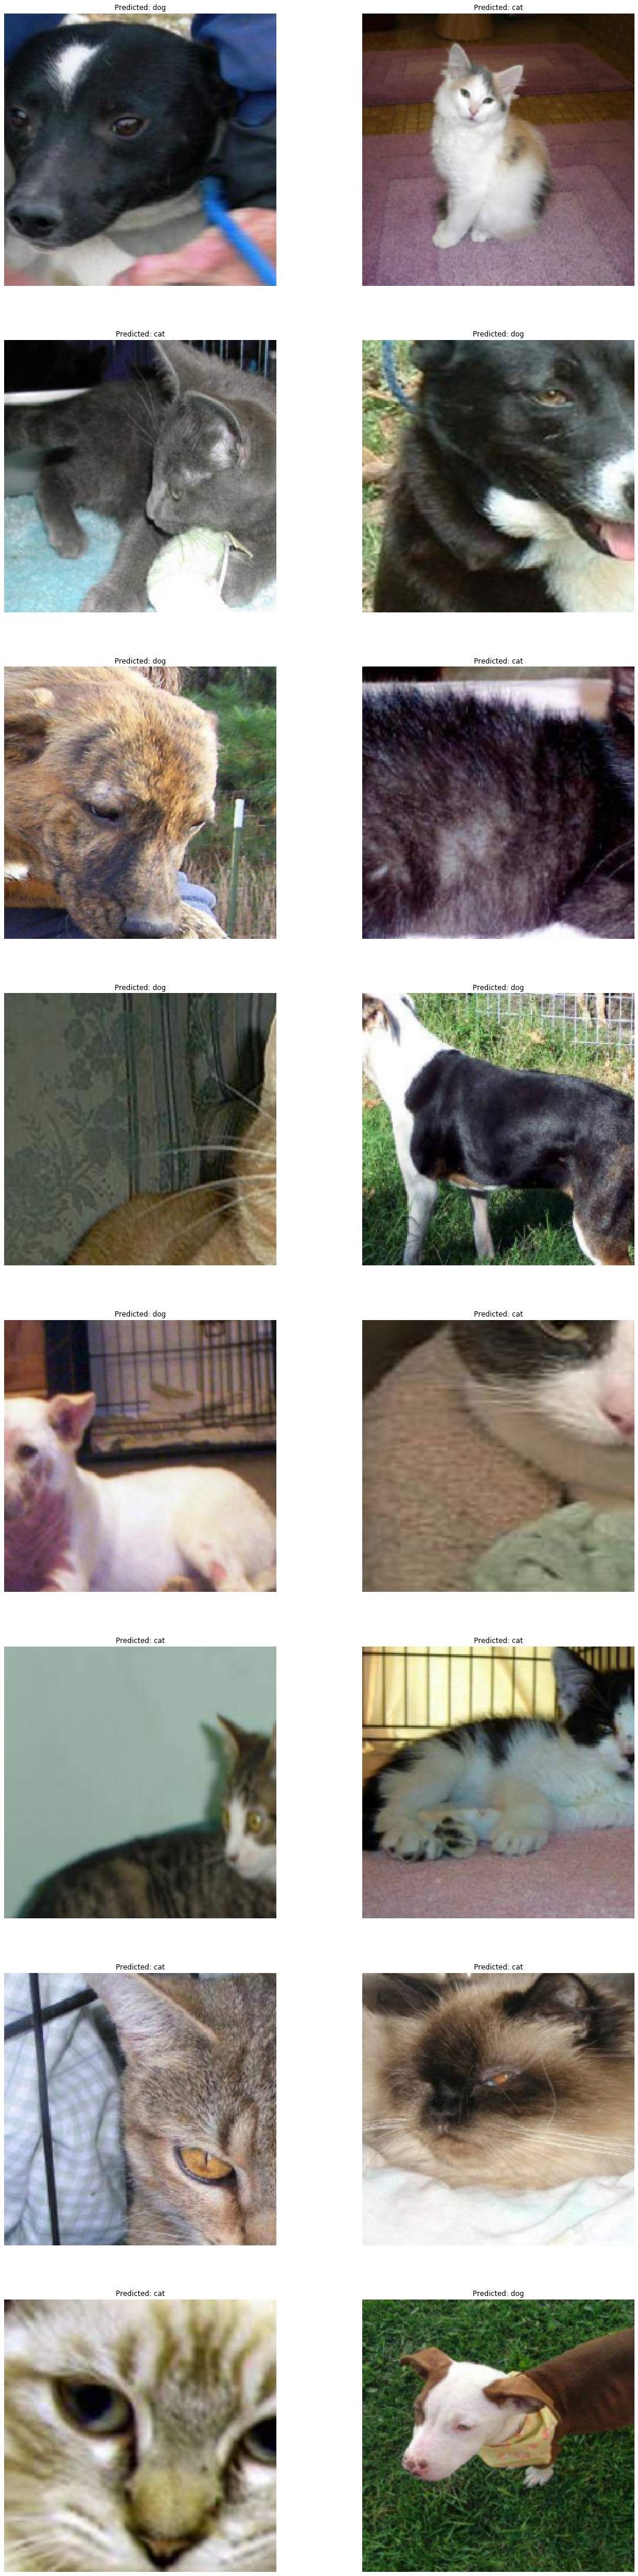

In [35]:
show_train_preds(imgs_n_preds)